# Wildfire Image Classification Project ML Pipeline 

In [25]:
import os
import torch
import random
import gc
from glob import glob
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.models import resnet152
from torchvision.models import vit_l_16
import imagehash
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from typing import List, Tuple, Set
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import ndarray
from sklearn.neighbors import BallTree
from collections import Counter
from functools import partial
from sklearn.cluster import KMeans

ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.rcParams["figure.facecolor"] = 'w'

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cuda'

In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Helper Functions

##### Obtaining (Near) Duplicate Images
Perceptual hashing (pHash) is used to represent the visual content of images in a compact and consistent manner by converting an image into a hash value that uniquely represents its visual characteristics. The hamming distance measure between the binary of the hashes is used to determine the similarity between images. The process of pHash is explained [here](https://hackerfactor.com/blog/index.php%3F/archives/432-Looks-Like-It.html).

In [28]:
def getBinaryArrayAsString(arr: ndarray):
  return ''.join('1' if x else '0' for x in arr.hash.flatten())

In [29]:
def removeSimilarImages(image_paths: Set[str], threshold: float) -> Tuple[int, List[Tuple[str, str]], Set[str]]:
  '''
  Removes (Near) duplicate images using Fast-implementation of kNN using BallTree.
  
  Returns:
  - Number of images with exact hash
  - A list pairs of near duplicate images where the second path is the removed path
  - A list of image paths that is free from any near duplicate images to the specified threshold
  '''
  
  def process_similar_items(removed_path: Set[str], distances: ndarray, indices: ndarray, curr_path: str) -> bool:
    for i in range(0, len(distances)):
      similarHashKey = ''.join(data[indices[i]].flatten())
      similarity = 1 - distances[i]
      
      if similarity >= threshold:
        similarPath = hash_image_dict[similarHashKey]
        near_duplicates.append((curr_path, similarPath))
        removed_path.add(similarPath)
      else:
        return False
    return True

  hash_image_dict = {getBinaryArrayAsString(imagehash.dhash(Image.open(path))): path for path in image_paths}
  num_exact_images = len(image_paths) - len(hash_image_dict)
  near_duplicates = [] 
  removed_path = set()
  
  data = np.array([list(value) for value in list(hash_image_dict.keys())])
  ballt = BallTree(data, metric='hamming')

  for hash, path in hash_image_dict.items():
    if (path in removed_path):
      continue
    
    k = 1   
    need_to_increase_k = True
    while need_to_increase_k:
      distances, indices = ballt.query([list(hash)], k=(k + 5), return_distance=True, sort_results=True)
      distances = distances.flatten()[k:]
      indices = indices.flatten()[k:]
      need_to_increase_k = process_similar_items(removed_path, distances, indices, path)
      k += 5

  remaining_paths = set(image_paths) - removed_path
  return (num_exact_images, near_duplicates, remaining_paths)  

##### Plotting Helper Functions

In [30]:
def plotImagePairs(image_paths: List[Tuple[str, str]], title: str) -> None:
  assert len(image_paths) > 0, 'image_paths must contain at least one pair'
  
  fig, axs = plt.subplots(nrows=len(image_paths), ncols=2, figsize=(6, 3 * len(image_paths)))
  suptitle = fig.suptitle(title, fontsize=16)

  if (len(image_paths) == 1):
    axs[0].set_title(f'First Image')
    axs[1].set_title(f'Second Image')
    first_image = Image.open(image_paths[0][0]).resize([24, 24])
    second_image = Image.open(image_paths[0][1]).resize([24, 24])

    axs[0].imshow(first_image)
    axs[1].imshow(second_image)
    suptitle.set_y(1.02)
    plt.show()
    return
  
  axs[0,0].set_title(f'First Image')
  axs[0,1].set_title(f'Second Image')
  for i in range(len(image_paths)):
    first_image = Image.open(image_paths[i][0]).resize([24, 24])
    second_image = Image.open(image_paths[i][1]).resize([24, 24])

    axs[i,0].imshow(first_image)
    axs[i,1].imshow(second_image)

  first_subplot_position = axs[0, 0].get_position()
  first_subplot_y = first_subplot_position.y1
  suptitle.set_y(first_subplot_y + 0.2 / len(image_paths))
  plt.show()

In [31]:
def plotBarGraph(groups: List[str], values: List[int], title: str) -> None:
  assert len(groups) > 0, 'Groups must be at least 1'
  assert len(groups) == len(values), 'Groups and values must have the same length'
  
  fig, axs = plt.subplots()
  fig.suptitle(title, fontsize=16, y=0.97)
  axs.bar(groups, values, color='#003f5c')
  axs.yaxis.set_major_locator(MaxNLocator(integer=True))
  axs.set_ylim(bottom=0)
  plt.show()

In [32]:
def plot2StackedBarGraph(groups: List[str], first_values: List[int], second_values: List[int], legend: List[str], title: str) -> None:
  assert len(groups) > 0, 'Groups must be at least 1'
  assert len(groups) == len(first_values) == len(second_values), 'Groups and values must have the same length'
  assert len(legend) == 2, 'Legend should have a length of 2'
  
  fig, axs = plt.subplots()
  fig.suptitle(title, fontsize=16, y=0.97)
  axs.bar(groups, first_values, label=legend[0], color='#003f5c')
  axs.bar(groups, second_values, bottom = first_values, label=legend[1], color='#bc5090')
  axs.yaxis.set_major_locator(MaxNLocator(integer=True))
  axs.legend()
  axs.set_ylim(bottom=0)
  plt.show()

In [33]:
def plot3StackedBarGraph(groups: List[str], first_values: List[int], second_values: List[int], third_values: List[int], legend: List[str], title: str) -> None:
  assert len(groups) > 0, 'Groups must be at least 1'
  assert len(groups) == len(first_values) == len(second_values) == len(third_values), 'Groups and values must have the same length'
  assert len(legend) == 3, 'Legend should have a length of 3'
  
  fig, axs = plt.subplots()
  fig.suptitle(title, fontsize=16, y=0.97)
  axs.bar(groups, first_values, label=legend[0], color='#003f5c')
  axs.bar(groups, second_values, bottom = first_values, label=legend[1], color='#bc5090')
  axs.bar(groups, third_values, bottom = np.add(first_values, second_values), label=legend[2], color='#ffa600')
  axs.yaxis.set_major_locator(MaxNLocator(integer=True))
  axs.legend()
  axs.set_ylim(bottom=0)
  plt.show()

In [34]:
def plotPieChartGraph(title: str, sizes: List[int], labels: List[str], explode: List[int]) -> None:
  assert len(labels) > 0, 'Labels must be at least 1'
  assert len(labels) == len(sizes) == len(explode), 'Labels, sizes, and explode must have the same length'
  
  plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.3, explode=explode, shadow=True, startangle=90)
  plt.suptitle(title, fontsize=16, y=0.95)
  plt.figure(facecolor='white')
  plt.show()

##### Image Helper Methods

In [35]:
def isImageValid(image_path: str) -> bool:
  try:
    _ = Image.open(image_path)
    return True
  except:
    return False

### Hyper-Parameters

In [36]:
SIMILARITY_THRESHOLD = 0.80
IMAGE_SIZE = 224
BATCH_SIZE = 32
TRAIN_PERC = 0.8

### Image Preprocessing

##### Image Augmentation
- Resize: To make sure all the images will have the same size
- RandomHorizontalFlip: Data augmentation
- ToTensor: Since we are using pytorch it expects a tensor not a numpy; it will convert the values from 0-255 to 0-1
- Normalize: Normalises the mean and standard deviation of the rgb values to 0.5 for each of the 3 channels

In [37]:
transformer=transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(), 
  transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

##### Data Loader

In [38]:
data_path = os.path.join('data')

wildfire_paths = os.path.join('data', 'wildfire')
nowildfire_paths = os.path.join('data', 'nowildfire')

In [39]:
wildfire_image_paths = glob(wildfire_paths + '/*.jpg')
valid_wildfire_image_paths = [path for path in wildfire_image_paths if isImageValid(path)]
nowildfire_image_paths = glob(nowildfire_paths + '/*.jpg')
valid_nowildfire_image_paths = [path for path in nowildfire_image_paths if isImageValid(path)]

In [40]:
(num_exact_images_wildfire, near_duplicates_wildfire, remaining_paths_wildfire) = removeSimilarImages(valid_wildfire_image_paths, SIMILARITY_THRESHOLD)

In [41]:
(num_exact_images_nowildfire, near_duplicates_nowildfire, remaining_paths_nowildfire) = removeSimilarImages(valid_nowildfire_image_paths, SIMILARITY_THRESHOLD)

In [42]:
def isValidFile(image_path: str, valid_paths: List[str]) -> bool:
  return image_path in valid_paths

valid_data_paths = remaining_paths_wildfire.union(remaining_paths_nowildfire)
isValidDataFile = partial(isValidFile, valid_paths=valid_data_paths)

In [43]:
dataset = ImageFolder(data_path, transform=transformer, is_valid_file=isValidDataFile)
train_size = int(TRAIN_PERC * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

##### Data Analysis

This section aims to visualise the distribution and characteristics of the loaded data, including data distribution, number of corrupted image files, comparison between unique and duplicate images, and identification of exact and near-duplicate images.

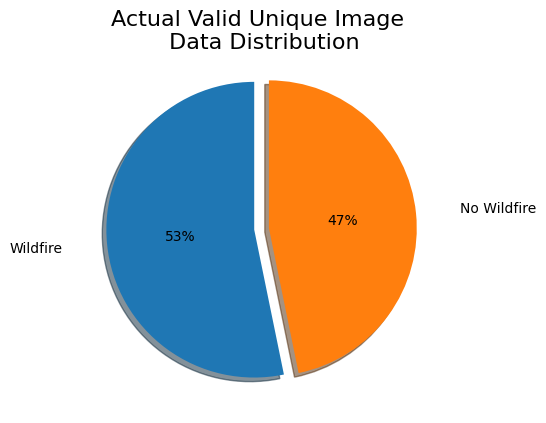

<Figure size 640x480 with 0 Axes>

In [45]:
classes = ['Wildfire', 'No Wildfire']
class_idx = dataset.class_to_idx
class_instance = dict(Counter(dataset.targets))

obtained_wildfire_count = class_instance[class_idx['wildfire']]
obtained_nowildfire_count = class_instance[class_idx['nowildfire']]

plotPieChartGraph(title='Actual Valid Unique Image \n Data Distribution', sizes=[obtained_wildfire_count, obtained_nowildfire_count], labels=classes, explode=[0.1, 0])

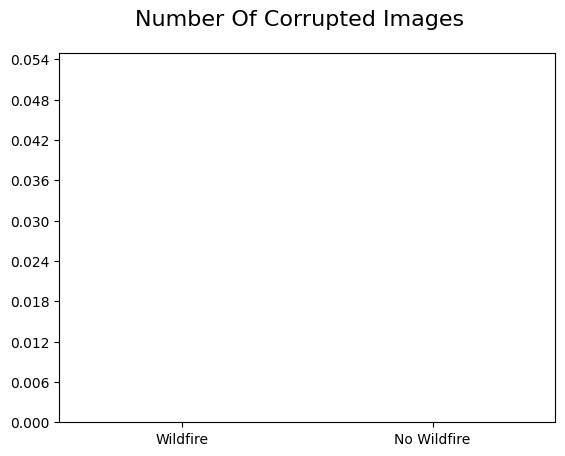

In [46]:
original_wildfire_count = len(wildfire_image_paths)
original_nowildfire_count = len(nowildfire_image_paths)

valid_wildfire_count = len(valid_wildfire_image_paths)
valid_nowildfire_count = len(valid_nowildfire_image_paths)

corrupted_wildfire_count = original_wildfire_count - valid_wildfire_count
corrupted_nowildfire_count = original_nowildfire_count - valid_nowildfire_count

plotBarGraph(groups=classes, values=[corrupted_wildfire_count, corrupted_nowildfire_count], title='Number Of Corrupted Images')

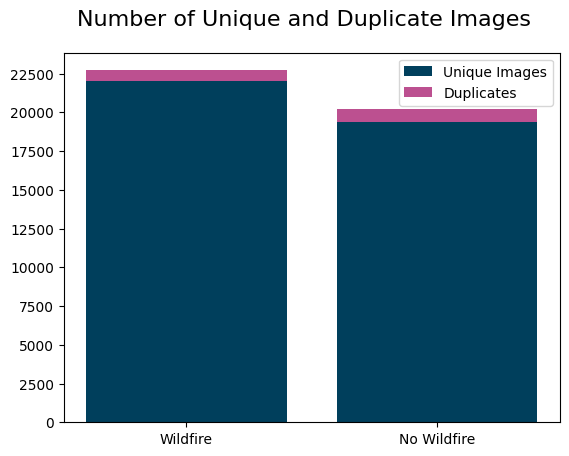

In [47]:
near_duplicates_wildfire_as_set = set([path[1] for path in near_duplicates_wildfire])
near_duplicates_nowildfire_as_set = set([path[1] for path in near_duplicates_nowildfire])

near_duplicates_wildfire_count = len(near_duplicates_wildfire_as_set)
near_duplicates_nowildfire_count = len(near_duplicates_nowildfire_as_set)

first_values = [obtained_wildfire_count, obtained_nowildfire_count]
second_values = [near_duplicates_wildfire_count + num_exact_images_wildfire, near_duplicates_nowildfire_count + num_exact_images_nowildfire]
legend = ['Unique Images', 'Duplicates']
plot2StackedBarGraph(classes, first_values, second_values, legend, 'Number of Unique and Duplicate Images')

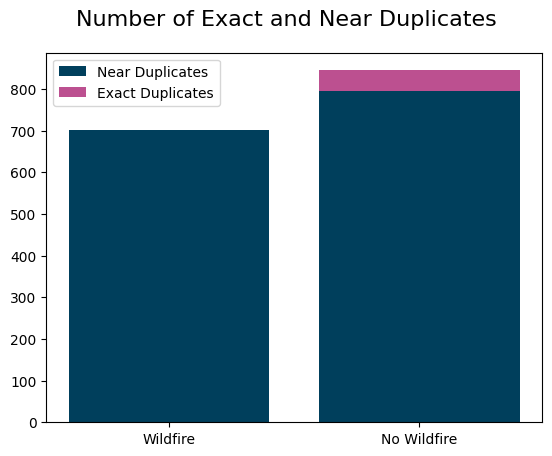

In [48]:
first_values = [near_duplicates_wildfire_count, near_duplicates_nowildfire_count]
second_values = [num_exact_images_wildfire, num_exact_images_nowildfire]
legend = ['Near Duplicates', 'Exact Duplicates']
plot2StackedBarGraph(classes, first_values, second_values, legend, 'Number of Exact and Near Duplicates')

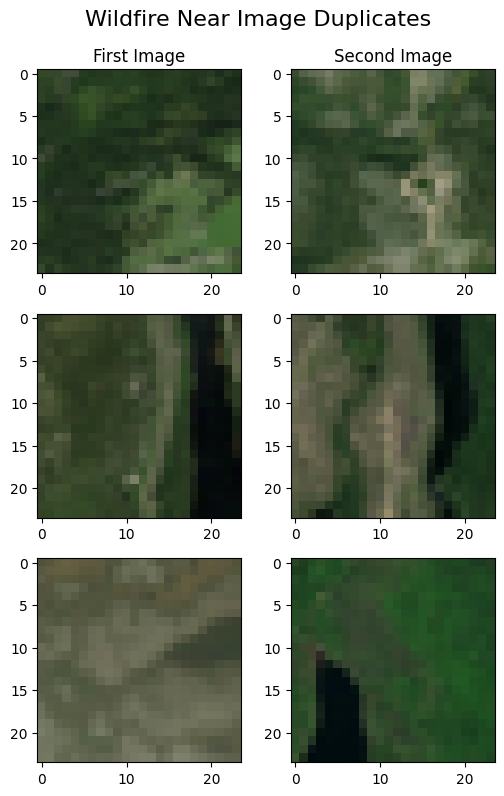

In [49]:
subsample_wildfire_near_duplicates = random.sample(near_duplicates_wildfire, 3)
plotImagePairs(subsample_wildfire_near_duplicates, title='Wildfire Near Image Duplicates')

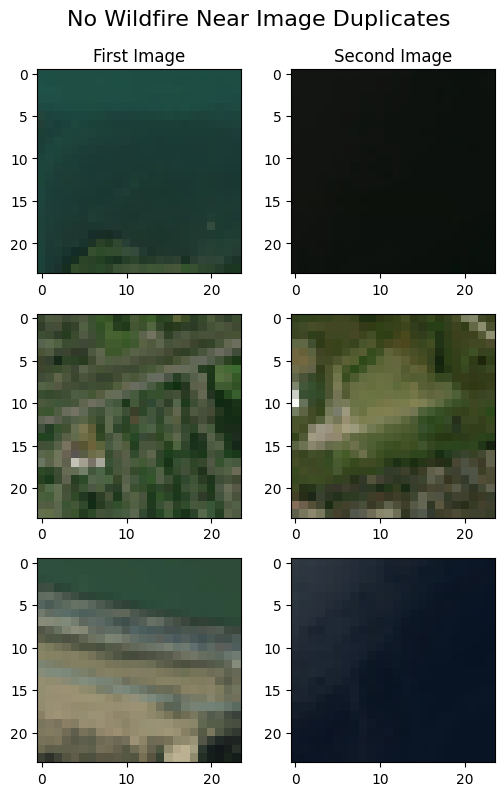

In [50]:
subsample_nowildfire_near_duplicates = random.sample(near_duplicates_nowildfire, 3)
plotImagePairs(subsample_nowildfire_near_duplicates, title='No Wildfire Near Image Duplicates')

### ResNet152

#### Hyperparameters

In [51]:
RESNET_LEARNING_RATE = 0.001
RESNET_MOMENTUM = 0.9
RESNET_LOSS_THRESHOLD = 0.005

In [52]:
resnet152_model = resnet152(weights=None) # OR resnet152_model = resnet152(pretrained=False) depending on the pytorch version you installed
resnet152_model = resnet152_model.to(device)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet152_model.parameters(), lr=RESNET_LEARNING_RATE, momentum=RESNET_MOMENTUM)

In [54]:
# Training step
epoch = 0
previous_loss = 0
loss_values = []

stay_in_loop = True
while(stay_in_loop):
    print(epoch+1)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet152_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        running_loss += current_loss
        if (abs(current_loss - previous_loss) <= RESNET_LOSS_THRESHOLD):
            print('Stop threshold reached')
            print(f'[{epoch+1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            stay_in_loop = False
            break
        previous_loss = current_loss
        
        # print statistics
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch+1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    
    loss_values.append(running_loss / len(train_dataset))
    epoch += 1
    
plt.plot(loss_values)

In [55]:
# Save model
torch.save(resnet152_model.state_dict(), './resnet_model.pth')

#### Model can be found at https://drive.google.com/file/d/1_82K3Xp0aaJg6-q69aftSQhZdUn6DzDh/view?usp=sharing

In [56]:
# Testing resnet
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet152_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [57]:
torch.cuda.empty_cache()
del resnet152_model
gc.collect()
torch.cuda.empty_cache()

## ViT

### HyperParameters

In [58]:
ViT_LEARNING_RATE = 0.001
ViT_MOMENTUM = 0.9
ViT_LOSS_THRESHOLD = 0.1

In [59]:
vit_model = vit_l_16(weights=None)
vit_model = vit_model.to(device)

In [60]:
criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.SGD(vit_model.parameters(), lr=ViT_LEARNING_RATE, momentum=ViT_MOMENTUM)

In [61]:
# Training step
epoch_ViT = 0
previous_loss_ViT = 0
loss_values_ViT = []

stay_in_loop_ViT = True
while(stay_in_loop_ViT):
    print(epoch_ViT+1)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_vit.zero_grad()

        # forward + backward + optimize
        outputs = vit_model(inputs)
        loss = criterion_vit(outputs, labels)
        loss.backward()
        optimizer_vit.step()

        current_loss = loss.item()
        running_loss += current_loss
        if (abs(current_loss - previous_loss_ViT) <= ViT_LOSS_THRESHOLD):
            print('Stop threshold reached')
            print(f'[{epoch_ViT+1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            stay_in_loop_ViT = False
            break
        previous_loss_ViT = current_loss

        # print statistics
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch_ViT+1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

    loss_values_ViT.append(running_loss / len(train_dataset))
    epoch_ViT += 1

plt.plot(loss_values_ViT)

In [62]:
torch.save(vit_model.state_dict(), './vit_model.pth')

In [63]:
correct_pred_ViT = {classname: 0 for classname in classes}
total_pred_ViT = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred_ViT[classes[label]] += 1
            total_pred_ViT[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred_ViT.items():
    accuracy = 100 * float(correct_count) / total_pred_ViT[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

#### Model can be found at https://drive.google.com/file/d/1x2pPJr5upD8juCKqGL_qa9OTeg7wPHfT/view?usp=sharing

In [64]:
torch.cuda.empty_cache()
del vit_model
gc.collect()
torch.cuda.empty_cache()

### K-Means

In [ ]:
NUMBER_OF_CLUSTERS = 2

In [66]:
# Training Step
def convertTensorObjectToNPArray(dataset):
  features = []
  for data, _ in dataset:
    features.append(data.numpy().flatten())  

  features = np.array(features)
  return features

train_dataset_array = convertTensorObjectToNPArray(train_dataset)

kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0, n_init="auto")
kmeans.fit_predict(train_dataset_array)


c:\Users\kenny\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


NameError: name 'label' is not defined

In [1]:
# Calculate accuracy


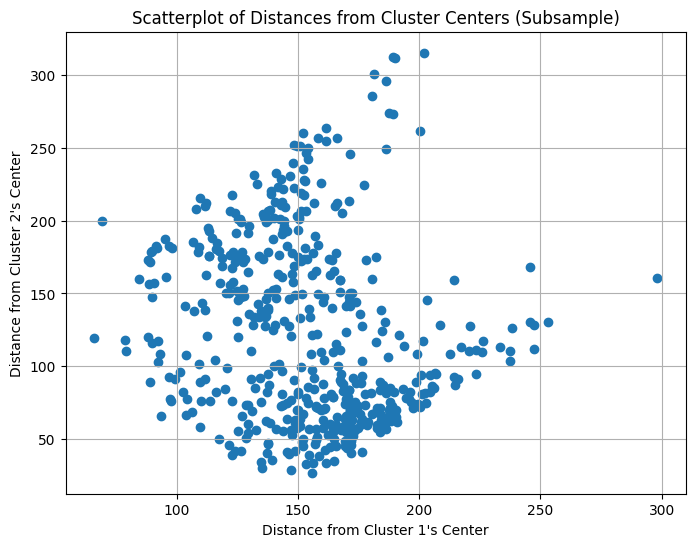

In [78]:
# Plot Scatterplot
cluster_centers = kmeans.cluster_centers_

# Calculate distances for a subsample of points
subsample_size = 500  # Adjust this as needed
subsample_indices = np.random.choice(len(train_dataset_array), size=subsample_size)
subsample_points = train_dataset_array[subsample_indices]

distances_from_center1 = np.linalg.norm(subsample_points - cluster_centers[0], axis=1)
distances_from_center2 = np.linalg.norm(subsample_points - cluster_centers[1], axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(distances_from_center1, distances_from_center2)

plt.xlabel("Distance from Cluster 1's Center")
plt.ylabel("Distance from Cluster 2's Center")
plt.title("Scatterplot of Distances from Cluster Centers (Subsample)")
plt.grid(True)
